In [1]:
# This notebook calcualtes summary tables for a range of heat, drough, rainfall and runoff hazard metrics
# each metric need slightly different code to calculate the min median and max values of the regional averages for the ensemble of models
# due to different collection of models and different fiel naming conventions.

In [2]:
cd /g/data/mn51/users/gt3409/plotting_maps/

/g/data/mn51/users/gt3409/plotting_maps


In [3]:
# import needed packages
from acs_area_statistics import acs_regional_stats, get_regions

import xarray as xr
import geopandas as gpd
import regionmask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob

In [4]:
# mask
# this shows fractional mask
mask_ncra = xr.open_dataset("/g/data/ia39/aus-ref-clim-data-nci/shapefiles/masks/AGCD-05i/mask-3D-frac-approx_ncra-regions.nc")['mask']
mask_aust = xr.open_dataset("/g/data/ia39/aus-ref-clim-data-nci/shapefiles/masks/AGCD-05i/mask-3D-frac-approx_australia.nc")['mask']

mask = xr.concat([mask_ncra, mask_aust], dim="region")
mask = mask.assign_coords({"region":np.arange(0,len(mask["region"]))})


In [5]:
def ens_summary_plots(path, var, gwls, mask, ):

    gwl_list =[]
    
    for gwl in gwls:

        filelist = glob(f"{path}/*{var}*{gwl}*.nc")
        ds_gwl = xr.open_mfdataset(filelist, 
                                   preprocess= lambda ds:ds.expand_dims({"gwl":[f"{gwl}"]}),
                                   use_cftime=True,
                                   combine="nested",
                                   concat_dim="model",
                                   combine_attrs= "drop_conflicts").load()
        gwl_list.append(ds_gwl)
    
    ds = xr.merge(gwl_list)
    
    # calculate the region average
    dims = ("lat", "lon",)
    how = ["mean",]
    
    da_summary = acs_regional_stats(ds=ds, var=var, mask = mask, dims=dims, how = how,)
    da_summary
    
    #find the min, median and max of ensemble members
    ds_min_max = xr.merge([da_summary.min(dim=["model"]).rename({f"{var}_mean":"min"}),
                            da_summary.median(dim=["model"]).rename({f"{var}_mean":"median"}),
                            da_summary.max(dim=["model"]).rename({f"{var}_mean":"max"}),])
    
    return ds_min_max
    


In [6]:
var="TXx"
gwls=["GWL12", "GWL15", "GWL20", "GWL30"]
path = f"/g/data/ia39/ncra/heat/data/{var}/bias-corrected/individual_models/GWL-average"
mask=mask

ds_min_max = ens_summary_plots(path, var, gwls, mask, )

# save to csv per region
for i, abbrev in enumerate(mask.abbrevs.values):
    df = ds_min_max.sel(region=i).to_dataframe()[["abbrevs", "names", "min", "median","max"]]
    df.to_csv(f"tables/{var}_{abbrev}_gwl-average.csv")

In [7]:
df

,abbrevs,names,min,median,max
gwl,,,,,
GWL12,AUS,Australia,43.126855,43.720360,44.016879
GWL15,AUS,Australia,43.598278,43.978857,44.635914
GWL20,AUS,Australia,44.217462,44.560178,45.263641
GWL30,AUS,Australia,44.929020,45.836529,46.867243


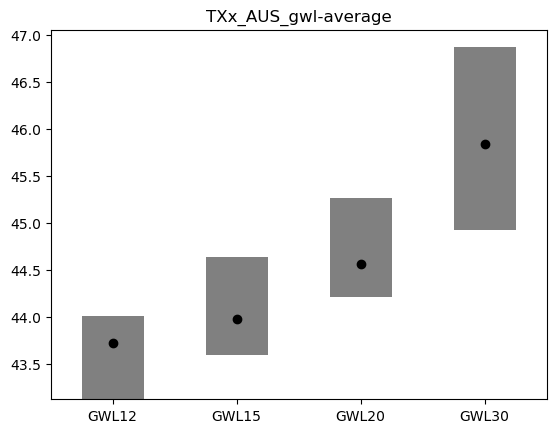

In [8]:
# make a plot from the csv

filename = f"{var}_{abbrev}_gwl-average"

df = pd.read_csv(f"{filename}.csv", index_col="gwl")

gwls = ["GWL12", "GWL15", "GWL20", "GWL30"]
for i, gwl in enumerate(gwls):

    ens_min, ens_median, ens_max = df.loc[[gwl]][["min", "median", "max"]].values[0]
    plt.bar(x=i+1, height=ens_max - ens_min, width=0.5, bottom =  ens_min, color="grey", label=gwl)
    plt.scatter(x=i+1, y=ens_median, c="k")


plt.xlim(0.5, len(gwls)+0.5 )
plt.xticks(np.arange(1,len(gwls)+1), labels=gwls)
plt.title(f"{filename}")

plt.savefig(f"figures/{filename}.png")

In [9]:
# anomalies
var="TXx"

gwl_list =[]

gwls=["GWL15", "GWL20", "GWL30"]

ds_min_max = ens_summary_plots(path, var, gwls, mask, )

# save to csv per region
for i, abbrev in enumerate(mask.abbrevs.values):
    df = ds_min_max.sel(region=i).to_dataframe()[["abbrevs", "names", "min", "median","max"]]
    df.to_csv(f"tables/{var}_{abbrev}_gwl-change.csv")


In [10]:
df

,abbrevs,names,min,median,max
gwl,,,,,
GWL15,AUS,Australia,43.598278,43.978857,44.635914
GWL20,AUS,Australia,44.217462,44.560178,45.263641
GWL30,AUS,Australia,44.929020,45.836529,46.867243


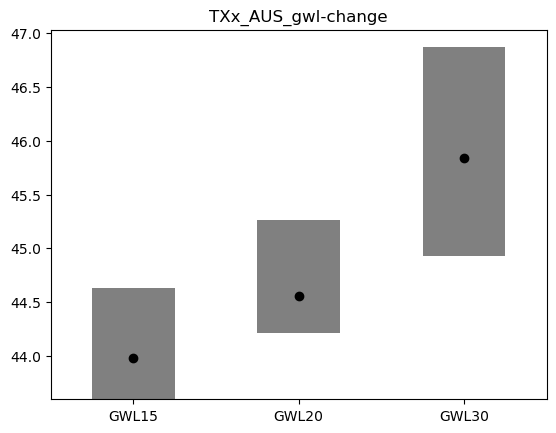

In [11]:
# make a plot from the csv

filename = f"{var}_{abbrev}_gwl-change"
df = pd.read_csv(f"tables/{filename}.csv", index_col="gwl")
gwls = ["GWL15", "GWL20", "GWL30"]


for i, gwl in enumerate(gwls):
    ens_min, ens_median, ens_max = df.loc[[gwl]][["min", "median", "max"]].values[0]
    plt.bar(x=i+1, height=ens_max - ens_min, width=0.5, bottom =  ens_min, color="grey", label=gwl)
    plt.scatter(x=i+1, y=ens_median, c="k")


plt.xlim(0.5, len(gwls)+0.5 )
plt.xticks(np.arange(1,len(gwls)+1), labels=gwls)
plt.title(f"{filename}")

plt.savefig(f"figures/{filename}.png")

In [12]:
# more variables

In [13]:
rounding_dict = {"TXx":1, "TXm":1, "TGm":1, "TXge35":0, "TXge40":0, "TXge45":0, "TNle02":0, "HW_sev_ext":0, "HWAtx":1}

In [14]:
# heat hazards -average
gwls=["GWL12", "GWL15", "GWL20", "GWL30"]

for var in ["TXx", "TXm", "TGm", "TXge35", "TXge40", "TXge45", "TNle02", "HW_sev_ext", "HWAtx"]:
    path = f"/g/data/ia39/ncra/heat/data/{var}/bias-corrected/individual_models/GWL-average"
   
    ds_min_max = ens_summary_plots(path, var, gwls, mask, ).round(rounding_dict[var])
    if rounding_dict[var] ==0:
        ds_min_max = ds_min_max.astype("int")
        
    df = ds_min_max.to_dataframe().reset_index()[["gwl", "abbrevs", "names", "min", "median","max"]]
    df.to_csv(f"tables/{var}_ncra-regions_gwl-average.csv")
    
    # save to csv per region
    for i, abbrev in enumerate(mask.abbrevs.values):
        df = ds_min_max.sel(region=i).to_dataframe()[["abbrevs", "names", "min", "median","max"]]
        df.to_csv(f"tables/{var}_{abbrev}_gwl-average.csv")

In [15]:
# heat hazards - change
gwls=["GWL15", "GWL20", "GWL30"]

for var in ["TXx", "TXm", "TGm", "TXge35", "TXge40", "TXge45", "TNle02", "HW_sev_ext", "HWAtx"]:
    path = f"/g/data/ia39/ncra/heat/data/{var}/bias-corrected/individual_models/GWL-change"
   
    ds_min_max = ens_summary_plots(path, var, gwls, mask,).round(rounding_dict[var])
    if rounding_dict[var] ==0:
        ds_min_max = ds_min_max.astype("int")
        
    df = ds_min_max.to_dataframe().reset_index()[["gwl", "abbrevs", "names", "min", "median","max"]]
    df.to_csv(f"tables/{var}_ncra-regions_gwl-change.csv")
    
    # save to csv per region
    for i, abbrev in enumerate(mask.abbrevs.values):
        df = ds_min_max.sel(region=i).to_dataframe()[["abbrevs", "names", "min", "median","max"]]
        df.to_csv(f"tables/{var}_{abbrev}_gwl-change.csv")

In [16]:
#XTS
gwls=["GWL12", "GWL15", "GWL20", "GWL30"]
rounding = 1

for var in ["low_freq"]:
    path = f"/g/data/ia39/ncra/extratropical_storms/5km/GWLs"

    gwl_list =[]
    
    for gwl in gwls:

        filelist = glob(f"{path}/lows_AGCD-05i_*_ssp370_r*i*p*_*_v1-r1_{gwl}.nc")
        
        ds_gwl = xr.open_mfdataset(filelist, 
                                   preprocess= lambda ds:ds.expand_dims({"gwl":[f"{gwl}"]}),
                                   use_cftime=True,
                                   combine="nested",
                                   concat_dim="model",
                                   combine_attrs= "drop_conflicts").load()
        gwl_list.append(ds_gwl)
    
    ds = xr.merge(gwl_list)
    
    # calculate the region average
    dims = ("lat", "lon",)
    how = ["mean",]
    
    da_summary = acs_regional_stats(ds=ds, var=var, mask = mask, dims=dims, how = how,)
    
    #find the min, median and max of ensemble members
    ds_min_max = xr.merge([da_summary.min(dim=["model"]).rename({f"{var}_mean":"min"}),
                            da_summary.median(dim=["model"]).rename({f"{var}_mean":"median"}),
                            da_summary.max(dim=["model"]).rename({f"{var}_mean":"max"}),])
   
    ds_min_max = ds_min_max.round(rounding)
        
    df = ds_min_max.to_dataframe().reset_index()[["gwl", "abbrevs", "names", "min", "median","max"]]
    df.to_csv(f"tables/{var}_ncra-regions_gwl-average.csv")
    
    # save to csv per region
    for i, abbrev in enumerate(mask.abbrevs.values):
        df = ds_min_max.sel(region=i).to_dataframe()[["abbrevs", "names", "min", "median","max"]]
        df.to_csv(f"tables/{var}_{abbrev}_gwl-average.csv")

In [17]:
# extreme rainfall
gwls=["GWL12", "GWL15", "GWL20", "GWL30"]
rounding = 1

for i, var in enumerate(["RX1D", "RX5D", "RX1H"]):
    path = f"/g/data/ia39/ncra/extratropical_storms/bias-corrected/ACS-QME-AGCD-1960-2022/GWLs"

    stats_var = ["prAdjust", "prAdjust", "prhmax"][i]
    gwl_list =[]
    
    for gwl in gwls:

        filelist = glob(f"{path}/{var}_AGCD-05i_*_ssp370_r*_*_v1-r1-ACS-QME-AGCD-1960-2022_{gwl}.nc")
        
        ds_gwl = xr.open_mfdataset(filelist, 
                                   preprocess= lambda ds:ds.expand_dims({"gwl":[f"{gwl}"]}),
                                   use_cftime=True,
                                   combine="nested",
                                   concat_dim="model",
                                   combine_attrs= "drop_conflicts").load()
        gwl_list.append(ds_gwl)
    
    ds = xr.merge(gwl_list)
    
    # calculate the region average
    dims = ("lat", "lon",)
    how = ["mean",]

    da_summary = acs_regional_stats(ds=ds, var=stats_var, mask = mask, dims=dims, how = how,)
    
    #find the min, median and max of ensemble members
    ds_min_max = xr.merge([da_summary.min(dim=["model"]).rename({f"{stats_var}_mean":"min"}),
                            da_summary.median(dim=["model"]).rename({f"{stats_var}_mean":"median"}),
                            da_summary.max(dim=["model"]).rename({f"{stats_var}_mean":"max"}),])
   
    ds_min_max = ds_min_max.round(rounding)
    if rounding==0:
        ds_min_max = ds_min_max.astype("int")
        
    df = ds_min_max.to_dataframe().reset_index()[["gwl", "abbrevs", "names", "min", "median","max"]]
    df.to_csv(f"tables/{var}_ncra-regions_gwl-average.csv")
    
    # save to csv per region
    for i, abbrev in enumerate(mask.abbrevs.values):
        df = ds_min_max.sel(region=i).to_dataframe()[["abbrevs", "names", "min", "median","max"]]
        df.to_csv(f"tables/{var}_{abbrev}_gwl-average.csv")

In [18]:
# extreme runoff
gwls=["1.2", "1.5", "2", "3"]
rounding = 1

for var in["max1day_runoff"]:
    path = f"/g/data/ia39/ncra/flood/Runoff_Max1D/runoff_max1day_ens/"
    stats_var = f"qtot"

    gwl_list =[]
    for gwl in gwls:

        filelist = glob(f"{path}/max1day_runoff_ens_rcp85_*_*_{gwl}.nc")
        
        ds_gwl = xr.open_mfdataset(filelist, 
                                   preprocess= lambda ds:ds.expand_dims({"gwl":[f"{gwl}"]}),
                                   use_cftime=True,
                                   combine="nested",
                                   concat_dim="model",
                                   combine_attrs= "drop_conflicts").load()
        gwl_list.append(ds_gwl)
    
    ds = xr.merge(gwl_list)
    ds = ds.rename({"latitude":"lat", "longitude": "lon"})
    
    # calculate the region average
    dims = ("lat", "lon",)
    how = ["mean",]

    da_summary = acs_regional_stats(ds=ds, var=stats_var, mask = mask, dims=dims, how = how,)
    
    #find the min, median and max of ensemble members
    ds_min_max = xr.merge([da_summary.min(dim=["model"]).rename({f"{stats_var}_mean":"min"}),
                            da_summary.median(dim=["model"]).rename({f"{stats_var}_mean":"median"}),
                            da_summary.max(dim=["model"]).rename({f"{stats_var}_mean":"max"}),])
   
    ds_min_max = ds_min_max.round(rounding)
    if rounding==0:
        ds_min_max = ds_min_max.astype("int")
        
    df = ds_min_max.to_dataframe().reset_index()[["gwl", "abbrevs", "names", "min", "median","max"]]
    df.to_csv(f"tables/{var}_ncra-regions_gwl-average.csv")
    
    # save to csv per region
    for i, abbrev in enumerate(mask.abbrevs.values):
        df = ds_min_max.sel(region=i).to_dataframe()[["abbrevs", "names", "min", "median","max"]]
        df.to_csv(f"tables/{var}_{abbrev}_gwl-average.csv")

In [19]:
# extreme runoff
#R90PERC
# /g/data/ia39/ncra/flood/Runoff_annual_total_90perc/runoff_annual_total_90perc_gwl/proj_runoff_annual_90_perc_rcp85_*_{gwl}.nc


gwls=["1.2", "1.5", "2", "3"]
rounding = 1

for var in["runoff_annual_total_90perc"]:
    path = f"/g/data/ia39/ncra/flood/Runoff_annual_total_90perc/runoff_annual_total_90perc_gwl/"
    stats_var = f"qtot"

    gwl_list =[]
    for gwl in gwls:

        filelist = glob(f"{path}/proj_runoff_annual_90_perc_rcp85_*_{gwl}.nc")
        
        ds_gwl = xr.open_mfdataset(filelist, 
                                   preprocess= lambda ds:ds.expand_dims({"gwl":[f"{gwl}"]}),
                                   use_cftime=True,
                                   combine="nested",
                                   concat_dim="model",
                                   combine_attrs= "drop_conflicts").load()
        gwl_list.append(ds_gwl)
    
    ds = xr.merge(gwl_list)
    ds = ds.rename({"latitude":"lat", "longitude": "lon"})
    
    # calculate the region average
    dims = ("lat", "lon",)
    how = ["mean",]

    da_summary = acs_regional_stats(ds=ds, var=stats_var, mask = mask, dims=dims, how = how,)
    
    #find the min, median and max of ensemble members
    ds_min_max = xr.merge([da_summary.min(dim=["model"]).rename({f"{stats_var}_mean":"min"}),
                            da_summary.median(dim=["model"]).rename({f"{stats_var}_mean":"median"}),
                            da_summary.max(dim=["model"]).rename({f"{stats_var}_mean":"max"}),])
   
    ds_min_max = ds_min_max.round(rounding)
    if rounding==0:
        ds_min_max = ds_min_max.astype("int")
        
    df = ds_min_max.to_dataframe().reset_index()[["gwl", "abbrevs", "names", "min", "median","max"]]
    df.to_csv(f"tables/{var}_ncra-regions_gwl-average.csv")
    
    # save to csv per region
    for i, abbrev in enumerate(mask.abbrevs.values):
        df = ds_min_max.sel(region=i).to_dataframe()[["abbrevs", "names", "min", "median","max"]]
        df.to_csv(f"tables/{var}_{abbrev}_gwl-average.csv")

In [20]:
# drought

gwls=["GWL1.2", "GWL1.5", "GWL2.0", "GWL3.0"]

var = "SPI3"
path = f"/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km"


gwl_list =[]

for gwl in gwls:

    filelist = glob(f"{path}/SPI3_pct_time_below_-1_AGCD-05i_*_ssp370_r*_*_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_{gwl}.nc")

    ds_gwl = xr.open_mfdataset(filelist, 
                               preprocess= lambda ds:ds.expand_dims({"gwl":[f"{gwl}"]}),
                               use_cftime=True,
                               combine="nested",
                               concat_dim="model",
                               combine_attrs= "drop_conflicts").load()
    gwl_list.append(ds_gwl)

ds = xr.merge(gwl_list)

# calculate the region average
dims = ("lat", "lon",)
how = ["mean",]

da_summary = acs_regional_stats(ds=ds, var=var, mask = mask, dims=dims, how = how,)

#find the min, median and max of ensemble members
ds_min_max = xr.merge([da_summary.min(dim=["model"]).rename({f"{var}_mean":"min"}),
                        da_summary.median(dim=["model"]).rename({f"{var}_mean":"median"}),
                        da_summary.max(dim=["model"]).rename({f"{var}_mean":"max"}),])

ds_min_max = ds_min_max.round(rounding)
if rounding==0:
    ds_min_max = ds_min_max.astype("int")

df = ds_min_max.to_dataframe().reset_index()[["gwl", "abbrevs", "names", "min", "median","max"]]
df.to_csv(f"tables/{var}_ncra-regions_gwl-average.csv")
    
# save to csv per region
for i, abbrev in enumerate(mask.abbrevs.values):
    df = ds_min_max.sel(region=i).to_dataframe()[["abbrevs", "names", "min", "median","max"]]
    df.to_csv(f"tables/{var}_{abbrev}_gwl-average.csv")


In [21]:
# drought
# too many NaNs, cannot calculate

# gwls=["GWL12", "GWL15", "GWL20", "GWL30"]
# rounding = 1
# var = "AI"
# path = f"/g/data/ia39/ncra/drought_aridity/ai/nhp1_BC_5km/GWL"

# gwl_list =[]

# for gwl in gwls:

#     filelist = glob(f"{path}/{var}-atmospheric-based_NHP1-AUS-5_*_rcp85_r*_*2D_{gwl}.nc")

#     ds_gwl = xr.open_mfdataset(filelist, 
#                                preprocess= lambda ds:ds.expand_dims({"gwl":[f"{gwl}"]}),
#                                use_cftime=True,
#                                combine="nested",
#                                coords="minimal",
#                                concat_dim="model",
#                                combine_attrs= "drop_conflicts").load()
#     gwl_list.append(ds_gwl)

# ds = xr.merge(gwl_list, compat="override")

# # calculate the region average
# dims = ("lat", "lon",)
# how = ["median",]

# da_summary = acs_regional_stats(ds=ds, var=var, mask = mask, dims=dims, how = how,)

# #find the min, median and max of ensemble members
# ds_min_max = xr.merge([da_summary.min(dim=["model"]).rename({f"{var}_median":"min"}),
#                         da_summary.median(dim=["model"]).rename({f"{var}_median":"median"}),
#                         da_summary.max(dim=["model"]).rename({f"{var}_median":"max"}),])

# ds_min_max = ds_min_max.round(rounding)
# if rounding==0:
#     ds_min_max = ds_min_max.astype("int")

# df = ds_min_max.to_dataframe().reset_index()[["gwl", "abbrevs", "names", "min", "median","max"]]
# df.to_csv(f"tables/{var}_ncra-regions_gwl-average.csv")


# # save to csv per region
# for i, abbrev in enumerate(mask.abbrevs.values):
#     df = ds_min_max.sel(region=i).to_dataframe()[["abbrevs", "names", "min", "median","max"]]
#     df.to_csv(f"tables/{var}_{abbrev}_gwl-average.csv")


In [22]:
# drought

gwls=["GWL1.2", "GWL1.5", "GWL2.0", "GWL3.0"]
rounding = 1

var = "p15_3month"
path = f"/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs"

gwl_list =[]

for gwl in gwls:

    filelist = glob(f"{path}/p15_3month_AGCD-05i_*_{gwl}_ACS-QME-AGCD-1960-2022.nc")

    ds_gwl = xr.open_mfdataset(filelist, 
                               preprocess= lambda ds:ds.mean("month").expand_dims({"gwl":[f"{gwl}"]}),
                               use_cftime=True,
                               combine="nested",
                               concat_dim="model",
                               combine_attrs= "drop_conflicts").load()
    gwl_list.append(ds_gwl)

ds = xr.merge(gwl_list)

# calculate the region average
dims = ("lat", "lon",)
how = ["mean",]

da_summary = acs_regional_stats(ds=ds, var=var, mask = mask, dims=dims, how = how,)

#find the min, median and max of ensemble members
ds_min_max = xr.merge([da_summary.min(dim=["model"]).rename({f"{var}_mean":"min"}),
                        da_summary.median(dim=["model"]).rename({f"{var}_mean":"median"}),
                        da_summary.max(dim=["model"]).rename({f"{var}_mean":"max"}),])

ds_min_max = ds_min_max.round(rounding)
if rounding==0:
    ds_min_max = ds_min_max.astype("int")

# save to csv per region
for i, abbrev in enumerate(mask.abbrevs.values):
    df = ds_min_max.sel(region=i).to_dataframe()[["abbrevs", "names", "min", "median","max"]]
    df.to_csv(f"tables/{var}_{abbrev}_gwl-average.csv")


# Available heatmaps
- heat: TXx, 
- drought/aridity: SPI3<-1 (https://github.com/AusClimateService/hazards-drought/blob/main/spi/plot_spi.ipynb)
- flood: code not available, but heatmap pngs and csvs are g/data/ia39/ncra/flood/Runoff_Max1D/statistics_heat_maps/heatmap_runoff_percentage_change_GWL_2.png



